In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the associated packages
import pvanalytics
import rdtools
import json
import pvlib
import matplotlib.pyplot as plt
import pandas as pd
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.quality.time import shifts_ruptures
from pvanalytics.features import daytime
from pvanalytics.system import (is_tracking_envelope,
                                infer_orientation_fit_pvwatts)
from pvanalytics.features.clearsky import reno
from statistics import mode
import numpy as np
import ruptures as rpt
import os

# PVAnalytics QA Routine for AC Power Stream Data

- Functions from the PVAnalytics package can be used to assess the quality of systems’ PV data. 
- Data quality routine for an AC power data stream is illustrated
- Please refer to associated Jupyter notebooks in following repo for routines for temperature, irradiance, and wind speed: https://github.com/PV-Tutorials/2024_Analytics_Webinar

- First, import the power data stream from a PV installation under the [2023 solar data prize data set](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&limit=100&prefix=pvdaq%2F2023-solar-data-prize%2F).
- Data set is publicly available via the DOE Open Energy Data Initiative (OEDI) (https://data.openei.org/submissions/4568), under system ID 2107. Data is timezone-localized.

Satellite image of the site: 

![alt text](./images/2107_satellite_image.png "Title")

In [3]:
with open('./data/2107_system_metadata.json', 'r') as f:
    metadata = json.load(f)

tz = metadata['System']['timezone_code']

def parse_prize_csv(file, tz):
    df = pd.read_csv(file)
    df.index = pd.to_datetime(df['measured_on'])
    df.index = df.index.tz_localize(tz, ambiguous='NaT')
    df = df.loc[df.index.dropna()].copy()
    print(f'{file} {df.index.min()}:{df.index.max()}')
    return df

df_elect = parse_prize_csv('./data/2107_electrical_data.csv', tz)

power_columns = [x for x in df_elect.columns if 'power' in x]

latitude = metadata['Site']['latitude']
longitude = metadata['Site']['longitude']
 

./data/2107_electrical_data.csv 2017-11-01 00:00:00-07:00:2023-11-07 23:55:00-08:00


Next we select an AC power stream to analyze, and visualize it.


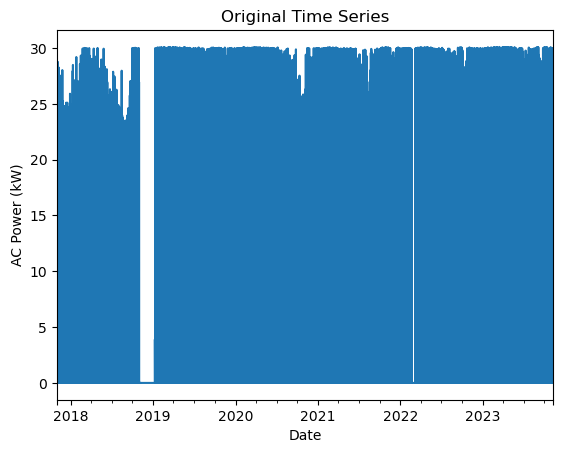

In [4]:
# Get power column and turn it into a series
col = 'inv_01_ac_power_inv_149583'
power_time_series = df_elect[col].copy()

# Get the time frequency of the time series
freq_minutes = int((mode(abs(np.diff(
    power_time_series.index)))).total_seconds() / 60)
data_freq = str(freq_minutes) + "min"

power_time_series = power_time_series.asfreq(data_freq)

# Show the original time series
power_time_series.plot(title="Original Time Series")
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.show()


# Basic Data Checks: Stale Data, Outliers, Abnormal Periods

Now, let’s run basic data checks to identify stale and abnormal/outlier data in the time series. Basic data checks include the following:

- Flatlined/stale data periods (which are not clipped or nighttime)
- Negative data
- “Abnormal” data days, which are days where the daily minimum is greater than 10% of the daily time series mean
- Outliers, which we set as 4 standard deviations away from the mean

In [5]:
# REMOVE STALE DATA (that isn't during nighttime periods or clipped)
# Day/night mask
daytime_mask = power_or_irradiance(power_time_series)
# Clipped data (uses rdtools filters)
clipping_mask = rdtools.filtering.xgboost_clip_filter(
    power_time_series)
stale_data_mask = gaps.stale_values_round(
    power_time_series,
    window=3,
    decimals=2)

stale_data_mask = (stale_data_mask & daytime_mask
                   & clipping_mask)
# REMOVE NEGATIVE DATA
negative_mask = (power_time_series < 0)
# FIND ABNORMAL PERIODS
daily_min = power_time_series.resample('D').min()   
series_min = 0.1 * power_time_series.mean()
erroneous_mask = (daily_min >= series_min)
erroneous_mask = erroneous_mask.reindex(
    index=power_time_series.index,
    method='ffill',
    fill_value=False)
# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(power_time_series,
                             zmax=4,
                             nan_policy='omit')


Now let's visualize all of the basic quality issues found during the previous data check.

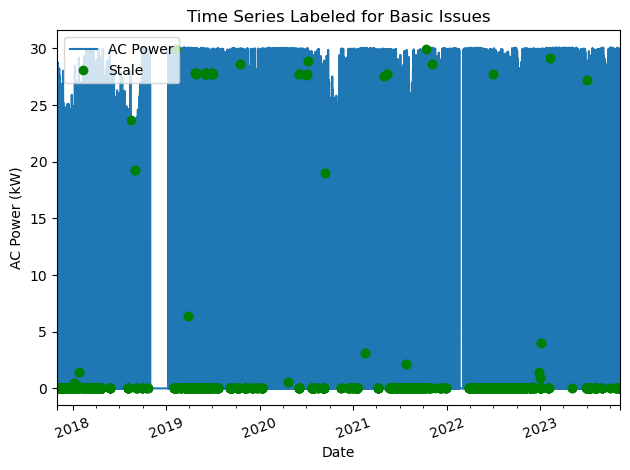

In [6]:
# Visualize all of the time series issues (stale,
# abnormal, outlier, etc)
power_time_series.plot()
labels = ["AC Power"]
if any(stale_data_mask):
    power_time_series.loc[stale_data_mask].plot(
        ls='', marker='o', color="green")
    labels.append("Stale")
if any(negative_mask):
    power_time_series.loc[negative_mask].plot(
        ls='', marker='o', color="orange")
    labels.append("Negative")
if any(erroneous_mask):
    power_time_series.loc[erroneous_mask].plot(
        ls='', marker='o', color="yellow")
    labels.append("Abnormal")
if any(zscore_outlier_mask):
    power_time_series.loc[zscore_outlier_mask].plot(
        ls='', marker='o', color="purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.tight_layout()
plt.show()

# Filter the time series, taking out all of the issues
issue_mask = ((~stale_data_mask) & (~negative_mask) &
          (~erroneous_mask) & (~zscore_outlier_mask))

power_time_series = power_time_series[issue_mask].copy()
power_time_series = power_time_series.asfreq(data_freq)

# Daily Completeness Score

Next, we filter the time series based on its daily completeness score. This filtering scheme requires at least 25% of data to be present for each day to be included.

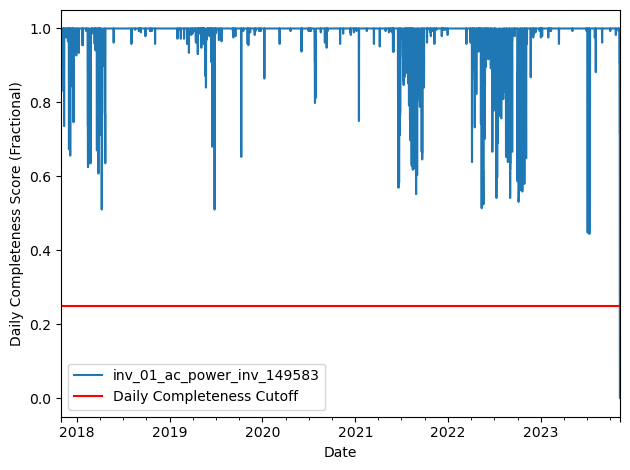

In [7]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(
    power_time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.axhline(y=0.25, color='r', linestyle='-',
            label='Daily Completeness Cutoff')
plt.legend()
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series_mask = \
pvanalytics.quality.gaps.trim_incomplete(
    power_time_series,
    minimum_completeness=.25,
    freq=data_freq)

power_time_series = power_time_series[trim_series_mask]
 

# Time Shift Check

Next, we check the time series for any time shifts, which may be caused by time drift or by incorrect time zone assignment. To do this, we compare the modelled midday time for the particular system location to its measured midday time, using PVAnalytics functionality. There should be DST present in this series, as the given timezone is US/Los Angeles. 

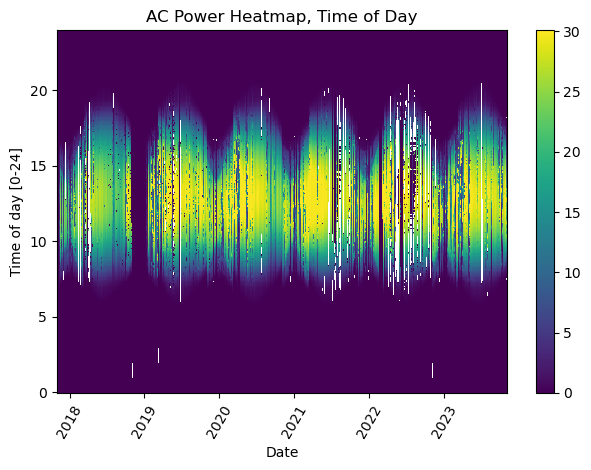

In [8]:
# Plot the heatmap of the AC power time series
plt.figure()
# Get time of day from the associated datetime column
time_of_day = pd.Series(
    power_time_series.index.hour +
    power_time_series.index.minute/60,
    index=power_time_series.index)
# Pivot the dataframe
dataframe = pd.DataFrame(pd.concat([power_time_series,
                                    time_of_day],
                                   axis=1))
dataframe.columns = ["values", 'time_of_day']
dataframe = dataframe.dropna()
dataframe_pivoted = dataframe.pivot_table(
    index='time_of_day', columns=dataframe.index.date,
    values="values")
plt.pcolormesh(dataframe_pivoted.columns,
               dataframe_pivoted.index,
               dataframe_pivoted,
               shading='auto')
plt.ylabel('Time of day [0-24]')
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.title('AC Power Heatmap, Time of Day')
plt.colorbar()
plt.tight_layout()
plt.show()


In [9]:
# Get the modeled sunrise and sunset time series based
# on the system's latitude-longitude coordinates
modeled_sunrise_sunset_df = \
pvlib.solarposition.sun_rise_set_transit_spa(
     power_time_series.index, latitude, longitude)

# Calculate the midday point between sunrise and sunset
# for each day in the modeled power series
modeled_midday_series = \
modeled_sunrise_sunset_df['sunrise'] + \
    (modeled_sunrise_sunset_df['sunset'] -
     modeled_sunrise_sunset_df['sunrise']) / 2

# Run day-night mask on the power time series
daytime_mask = power_or_irradiance(
    power_time_series, freq=data_freq,
    low_value_threshold=.005)

# Generate the sunrise, sunset, and halfway points
# for the data stream
sunrise_series = daytime.get_sunrise(daytime_mask)
sunset_series = daytime.get_sunset(daytime_mask)
midday_series = sunrise_series + ((sunset_series -
                                   sunrise_series)/2)

# Convert the midday and modeled midday series to daily
# values
midday_series_daily, modeled_midday_series_daily = (
    midday_series.resample('D').mean(),
    modeled_midday_series.resample('D').mean())

# Set midday value series as minutes since midnight,
# from midday datetime values
midday_series_daily = (
    midday_series_daily.dt.hour * 60 +
    midday_series_daily.dt.minute +
    midday_series_daily.dt.second / 60)
modeled_midday_series_daily = \
    (modeled_midday_series_daily.dt.hour * 60 +
     modeled_midday_series_daily.dt.minute +
     modeled_midday_series_daily.dt.second / 60)

# Estimate the time shifts by comparing the modelled
# midday point to the measured midday point.
is_shifted, time_shift_series = shifts_ruptures(
    midday_series_daily, modeled_midday_series_daily,
    period_min=15, shift_min=15, zscore_cutoff=1.5)


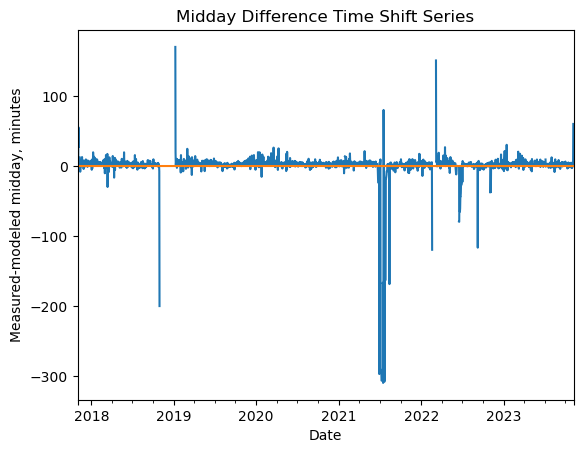

In [10]:
# Create a midday difference series between modeled and
# measured midday, to visualize time shifts. First,
# resample each time series to daily frequency, and
# compare the data stream's daily halfway point to
# the modeled halfway point
midday_diff_series = (
    midday_series.resample('D').mean() -
    modeled_midday_series.resample('D').mean()
                      ).dt.total_seconds() / 60

# Generate boolean for detected time shifts
if any(time_shift_series != 0):
    time_shifts_detected = True
else:
    time_shifts_detected = False

# Plot the difference between measured and modeled
# midday, as well as the CPD-estimated time shift series.
plt.figure()
midday_diff_series.plot() 
time_shift_series.plot()
plt.title("Midday Difference Time Shift Series")
plt.xlabel("Date")
plt.ylabel("Measured-modeled midday, minutes")
plt.show()


# Data/Capacity Shift Check

Next, we check the time series for any abrupt data shifts. We take the longest continuous part of the time series that is free of data shifts. We use [pvanalytics.quality.data_shifts.detect_data_shifts()](https://pvanalytics--202.org.readthedocs.build/en/202/generated/pvanalytics.quality.data_shifts.detect_data_shifts.html#pvanalytics.quality.data_shifts.detect_data_shifts) to detect data shifts in the time series.

In [11]:
# Set all values in the nighttime mask to 0
power_time_series.loc[~daytime_mask] = 0
# Resample the time series to daily mean
power_time_series_daily = power_time_series.resample(
    'D').mean()
data_shift_start_date, data_shift_end_date = \
ds.get_longest_shift_segment_dates(
    power_time_series_daily,
    use_default_models=False,
    method=rpt.Binseg, cost='rbf',
    penalty=20)
data_shift_period_length = (data_shift_end_date -
                            data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = ds.detect_data_shifts(
    power_time_series_daily, use_default_models=False,
    method=rpt.Binseg, cost='rbf', penalty=20)


In [12]:
# Get the shift dates
shift_dates = list(power_time_series_daily[
    data_shift_mask].index)
if len(shift_dates) > 0:
    shift_found = True
else: 
    shift_found = False
    
power_time_series = power_time_series[
        (power_time_series.index >=
         data_shift_start_date.tz_convert(
             power_time_series.index.tz)) &
        (power_time_series.index <=
         data_shift_end_date.tz_convert(
             power_time_series.index.tz))]

power_time_series = power_time_series.asfreq(data_freq)


Shift Found:  True


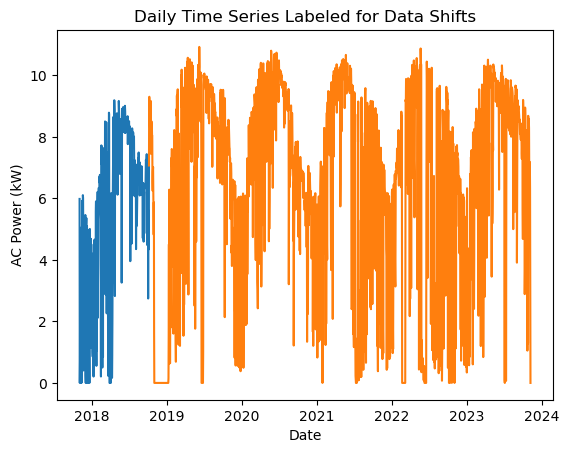

In [13]:
# Visualize the time shifts for the daily time series
print("Shift Found: ", shift_found)
edges = ([power_time_series_daily.index[0]] + shift_dates +
         [power_time_series_daily.index[-1]])
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(power_time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.xlabel("Date")
plt.ylabel("AC Power (kW)")
plt.show()


In [14]:
# Write the filtered data to a pickle

power_time_series.to_pickle(os.path.join("./data", col))

# Assessing Mounting Configuration

In addition to data filtering, PVAnalytics contains several functions for analyzing the system configurtion. Here, we verify that the mounting configuration is fixed-tilt based on the time series daily production profiles. 

In [15]:
# CHECK MOUNTING CONFIGURATION
daytime_mask = power_or_irradiance(power_time_series)
clipping_mask = ~rdtools.filtering.xgboost_clip_filter(power_time_series)
predicted_mounting_config = is_tracking_envelope(power_time_series,
                                                 daytime_mask,
                                                 clipping_mask)

print("Predicted Mounting configuration:")
print(predicted_mounting_config.name)


Predicted Mounting configuration:
FIXED


# Assessing Azimuth and Tilt

In addition to verifying mounting configuration, we estimate the azimuth and tilt of the system. Ground truth azimuth and tilt for this system are listed as 180 and 25 degrees, respectively. 

In [17]:
# Read in associated NSRDB data for the site.
power_time_series = power_time_series.dropna()

# We load in the PSM3 data from NSRDB for this
# particular location. This data is pulled via the
# following function in PVLib: 
# :py:func:`pvlib.iotools.get_psm3`
psm3 = pd.read_csv("./data/psm3_data.csv", parse_dates=True,
                  index_col =0)

psm3 = psm3.tz_convert(tz)

is_clear = (psm3.ghi_clear == psm3.ghi)
is_daytime = (psm3.ghi > 0)
time_series_clearsky = power_time_series[is_clear &
                                         is_daytime]
time_series_clearsky = time_series_clearsky.dropna()
psm3_clearsky = psm3.loc[time_series_clearsky.index]

# Get solar azimuth and zenith from pvlib, based on
# lat-long coords
solpos_clearsky = pvlib.solarposition.get_solarposition(
    time_series_clearsky.index, latitude, longitude)


In [ ]:
predicted_tilt, predicted_azimuth, r2 = \
infer_orientation_fit_pvwatts(
    time_series_clearsky,
    psm3_clearsky.ghi_clear,
    psm3_clearsky.dhi_clear,
    psm3_clearsky.dni_clear,
    solpos_clearsky.zenith,
    solpos_clearsky.azimuth,
    temperature=psm3_clearsky.temp_air,
)

# Compare actual system azimuth and tilt to predicted
# azimuth and tilt
print("Predicted azimuth: " + str(predicted_azimuth))
print("Predicted tilt: " + str(predicted_tilt))



# Thank you! For additional examples, check out PVAnalytics documentation: https://pvanalytics.readthedocs.io/en/stable/

![alt text](./images/pvanalytics-logo.png "Title")

